In [1]:
import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
import tensorflow_hub as hub
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import label_map_util

%matplotlib inline

In [2]:
class ObjectDetection:
    def __init__(self):
        PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
        self.category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
        
        tf.keras.backend.clear_session()
#         self.detect_fn = tf.saved_model.load('models/research/object_detection/test_data/efficientdet_d5_coco17_tpu-32/saved_model')
        
        ALL_MODELS = {
        'CenterNet HourGlass104 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512/1',
        'CenterNet HourGlass104 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/hourglass_512x512_kpts/1',
        'CenterNet HourGlass104 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024/1',
        'CenterNet HourGlass104 Keypoints 1024x1024' : 'https://tfhub.dev/tensorflow/centernet/hourglass_1024x1024_kpts/1',
        'CenterNet Resnet50 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512/1',
        'CenterNet Resnet50 V1 FPN Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v1_fpn_512x512_kpts/1',
        'CenterNet Resnet101 V1 FPN 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet101v1_fpn_512x512/1',
        'CenterNet Resnet50 V2 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512/1',
        'CenterNet Resnet50 V2 Keypoints 512x512' : 'https://tfhub.dev/tensorflow/centernet/resnet50v2_512x512_kpts/1',
        'EfficientDet D0 512x512' : 'https://tfhub.dev/tensorflow/efficientdet/d0/1',
        'EfficientDet D1 640x640' : 'https://tfhub.dev/tensorflow/efficientdet/d1/1',
        'EfficientDet D2 768x768' : 'https://tfhub.dev/tensorflow/efficientdet/d2/1',
        'EfficientDet D3 896x896' : 'https://tfhub.dev/tensorflow/efficientdet/d3/1',
        'EfficientDet D4 1024x1024' : 'https://tfhub.dev/tensorflow/efficientdet/d4/1',
        'EfficientDet D5 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d5/1',
        'EfficientDet D6 1280x1280' : 'https://tfhub.dev/tensorflow/efficientdet/d6/1',
        'EfficientDet D7 1536x1536' : 'https://tfhub.dev/tensorflow/efficientdet/d7/1',
        'SSD MobileNet v2 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/2',
        'SSD MobileNet V1 FPN 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v1/fpn_640x640/1',
        'SSD MobileNet V2 FPNLite 320x320' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_320x320/1',
        'SSD MobileNet V2 FPNLite 640x640' : 'https://tfhub.dev/tensorflow/ssd_mobilenet_v2/fpnlite_640x640/1',
        'SSD ResNet50 V1 FPN 640x640 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_640x640/1',
        'SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)' : 'https://tfhub.dev/tensorflow/retinanet/resnet50_v1_fpn_1024x1024/1',
        'SSD ResNet101 V1 FPN 640x640 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_640x640/1',
        'SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)' : 'https://tfhub.dev/tensorflow/retinanet/resnet101_v1_fpn_1024x1024/1',
        'SSD ResNet152 V1 FPN 640x640 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_640x640/1',
        'SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)' : 'https://tfhub.dev/tensorflow/retinanet/resnet152_v1_fpn_1024x1024/1',
        'Faster R-CNN ResNet50 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_640x640/1',
        'Faster R-CNN ResNet50 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_1024x1024/1',
        'Faster R-CNN ResNet50 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet50_v1_800x1333/1',
        'Faster R-CNN ResNet101 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_640x640/1',
        'Faster R-CNN ResNet101 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_1024x1024/1',
        'Faster R-CNN ResNet101 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet101_v1_800x1333/1',
        'Faster R-CNN ResNet152 V1 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_640x640/1',
        'Faster R-CNN ResNet152 V1 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_1024x1024/1',
        'Faster R-CNN ResNet152 V1 800x1333' : 'https://tfhub.dev/tensorflow/faster_rcnn/resnet152_v1_800x1333/1',
        'Faster R-CNN Inception ResNet V2 640x640' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_640x640/1',
        'Faster R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/faster_rcnn/inception_resnet_v2_1024x1024/1',
        'Mask R-CNN Inception ResNet V2 1024x1024' : 'https://tfhub.dev/tensorflow/mask_rcnn/inception_resnet_v2_1024x1024/1'
        }
        model_display_name = 'CenterNet HourGlass104 Keypoints 512x512' # @param ['CenterNet HourGlass104 512x512','CenterNet HourGlass104 Keypoints 512x512','CenterNet HourGlass104 1024x1024','CenterNet HourGlass104 Keypoints 1024x1024','CenterNet Resnet50 V1 FPN 512x512','CenterNet Resnet50 V1 FPN Keypoints 512x512','CenterNet Resnet101 V1 FPN 512x512','CenterNet Resnet50 V2 512x512','CenterNet Resnet50 V2 Keypoints 512x512','EfficientDet D0 512x512','EfficientDet D1 640x640','EfficientDet D2 768x768','EfficientDet D3 896x896','EfficientDet D4 1024x1024','EfficientDet D5 1280x1280','EfficientDet D6 1280x1280','EfficientDet D7 1536x1536','SSD MobileNet v2 320x320','SSD MobileNet V1 FPN 640x640','SSD MobileNet V2 FPNLite 320x320','SSD MobileNet V2 FPNLite 640x640','SSD ResNet50 V1 FPN 640x640 (RetinaNet50)','SSD ResNet50 V1 FPN 1024x1024 (RetinaNet50)','SSD ResNet101 V1 FPN 640x640 (RetinaNet101)','SSD ResNet101 V1 FPN 1024x1024 (RetinaNet101)','SSD ResNet152 V1 FPN 640x640 (RetinaNet152)','SSD ResNet152 V1 FPN 1024x1024 (RetinaNet152)','Faster R-CNN ResNet50 V1 640x640','Faster R-CNN ResNet50 V1 1024x1024','Faster R-CNN ResNet50 V1 800x1333','Faster R-CNN ResNet101 V1 640x640','Faster R-CNN ResNet101 V1 1024x1024','Faster R-CNN ResNet101 V1 800x1333','Faster R-CNN ResNet152 V1 640x640','Faster R-CNN ResNet152 V1 1024x1024','Faster R-CNN ResNet152 V1 800x1333','Faster R-CNN Inception ResNet V2 640x640','Faster R-CNN Inception ResNet V2 1024x1024','Mask R-CNN Inception ResNet V2 1024x1024']
        model_handle = ALL_MODELS[model_display_name]
    
        self.detect_fn = hub_model = hub.load(model_handle)

    def inference(self, image_np, logging=False):
        detections = self.detect_fn(image_np)
        detections = {key:value.numpy() for key,value in detections.items()}

        if logging:
            label_id_offset = 0
            image_np_with_detections = image_np.copy()
            viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections[0],
                detections['detection_boxes'][0],
                (detections['detection_classes'][0] + label_id_offset).astype(int),
                detections['detection_scores'][0],
                self.category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=200,
                min_score_thresh=.30,
                agnostic_mode=False)

            plt.figure(figsize=(24,32))
            plt.imshow(image_np_with_detections[0])
            plt.show()

        return detections
        

In [3]:
from quickdraw import QuickDrawData
import IPython
import os
import json
import random
import json
import cv2
import matplotlib.pyplot as plt
import numpy as np
import requests
from io import BytesIO
import base64
from math import trunc
from PIL import Image as PILImage
from PIL import ImageDraw as PILImageDraw
from pycocotools.coco import COCO
import numpy as np
import skimage.io as io
import matplotlib.pyplot as plt
import pylab

In [4]:
class QuickDrawDataset:
    def __init__(self):
        self.qd = QuickDrawData()
        self.coco_to_quickdraw = {
            "pizza": "pizza",
            "bus": "bus",
            "couch": "couch",
            "remote": "key",
            "snowboard": "skateboard",
            "fork": "fork",
            "suitcase": "suitcase",
            "scissors": "scissors",
            "sheep": "sheep",
#             "person": "scorpion",
            "person": "duck",
            "dog": "dog", 
            "cake": "cake",
            "tv": "television",
            "frisbee": "baseball",
            "carrot": "carrot",
            "bird": "bird",
            "bicycle": "bicycle",
            "cow": "cow",
            "cat": "cat",
            "bowl": "bathtub",
            "book": "book",
            "tie": "bowtie",
            "sink": "sink",
            "toothbrush": "toothbrush",
            "bed": "bed",
            "bear": "bear",
            "skateboard": "skateboard",
            "train": "train",
            "backpack": "backpack",
            "cup": "cup",
            "bottle": "wine bottle",
            "car": "car",
            "laptop": "laptop",
            "elephant": "elephant",
            "bench": "bench",
            "knife": "knife",
            "zebra": "zebra",
            "orange": "apple",
            "donut": "donut",
            "apple": "apple",
            "chair": "chair",
            "toilet": "toilet",
            "banana": "banana",
            "airplane": "airplane",
            "giraffe": "giraffe",
            "refrigerator": "cooler",
            "broccoli": "broccoli", 
            "clock": "clock", 
            "spoon": "fork", 
            "handbag": "purse", 
            "horse": "horse", 
            "toaster": "toaster", 
            "microwave": "microwave", 
            "motorcycle": "motorbike", 
            "vase": "vase", 
            "keyboard": "keyboard", 
            "skis": "lollipop", 
            "oven": "oven", 
            "kite": "postcard", 
            "surfboard": "skateboard", 
            "sandwich": "sandwich", 
            "truck": "truck", 
            "boat": "speedboat", 
            "umbrella": "umbrella", 
            "mouse": "mouse", 
            "traffic light": "traffic light", 
            "fire hydrant": "fire hydrant", 
            "stop sign": "stop sign", 
            "parking meter": "sword", 
            "sports ball": "soccer ball", 
            "baseball bat": "baseball bat", 
            "baseball glove": "hand", 
            "tennis racket": "tennis racquet", 
            "wine glass": "wine glass", 
            "hot dog": "hot dog", 
            "potted plant": "house plant", 
            "dining table": "table", 
            "cell phone": "cell phone", 
            "teddy bear": "teddy-bear", 
            "hair dryer": "drill" }
        PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
        self.category_index = label_map_util.create_category_index_from_labelmap(
            PATH_TO_LABELS, use_display_name=True)

    # Removes detections that either do not have a quickdraw equivalent annotations or have a score
    # below the threshold.
    def prune_detections(self, image_shape, detections, threshold):
        pruned_detections = []
        for i in range(int(detections['num_detections'][0])):
            if ((self.category_index[detections['detection_classes'][0][i]]['name'] in self.coco_to_quickdraw) and
                (detections['detection_scores'][0][i] > threshold)):
                quickdraw_class = self.coco_to_quickdraw[self.category_index[detections['detection_classes'][0][i]]['name']]
                old_bbox = detections['detection_boxes'][0][i]
                new_bbox = [old_bbox[1] * image_shape[1],
                            old_bbox[0] * image_shape[0],
                            (old_bbox[3] - old_bbox[1]) * image_shape[1],
                            (old_bbox[2] - old_bbox[0]) * image_shape[0]]
                pruned_detections.append({'class': quickdraw_class,'bbox': new_bbox})
    
        return pruned_detections
            
    def draw(self, image, detections, save_filename):
        I = image.copy()
        for detection in detections:
            drawing = self.qd.get_drawing(detection['class'])
            pil_im = drawing.image
#             pil_im.show()
#             plt.gca().invert_yaxis()
#             for stroke in drawing.strokes:
#                 xarr = []
#                 yarr = []
#                 for x, y in stroke:
#                     xarr.append(x)
#                     yarr.append(y)
#                 plt.plot(xarr,yarr, marker = ',', color="black")
#             plt.show()

            plt.axis('off')

            smallest_x = float('inf')
            smallest_y = float('inf')
            largest_x = 0
            largest_y = 0
            for stroke in drawing.strokes:
                xarr = []
                yarr = []

                for x, y in stroke:
                    xarr.append(x)
                    yarr.append(y)
                    if(x <= smallest_x):
                        smallest_x = x
                    if(y <= smallest_y):
                        smallest_y = y
                    if(x >= largest_x):
                        largest_x = x
                    if(y >= largest_y):
                        largest_y = y

            width = largest_x-smallest_x
            height = largest_y - smallest_y

#             print(smallest_x)
#             print(width, 'width')
#             print(largest_y)
#             print(height, 'height')

#         for ann in anns:
            [bbox_x, bbox_y, bbox_w, bbox_h] = detection['bbox']
            for stroke in drawing.strokes:
                xarr = []
                yarr = []
                for x, y in stroke:
                    xarr.append(x)
                    yarr.append(y)

                newx = [x * (bbox_w/width) + bbox_x for x in xarr]
                newy = [y * (bbox_h/height) + bbox_y for y in yarr]
                plt.plot(newx,newy, marker = ',', color="white")

        plt.imshow(I)
        plt.axis('off')
        plt.savefig(save_filename, bbox_inches='tight', pad_inches=0)
        plt.show()
        
        return I

In [5]:
object_detection = ObjectDetection()
qd_dataset = QuickDrawDataset()

In [6]:
from inpainting.inpaint import Inpainting
inpainting = Inpainting()

IMG_2531.jpeg


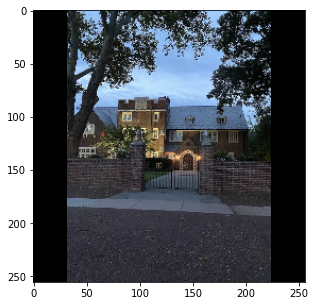

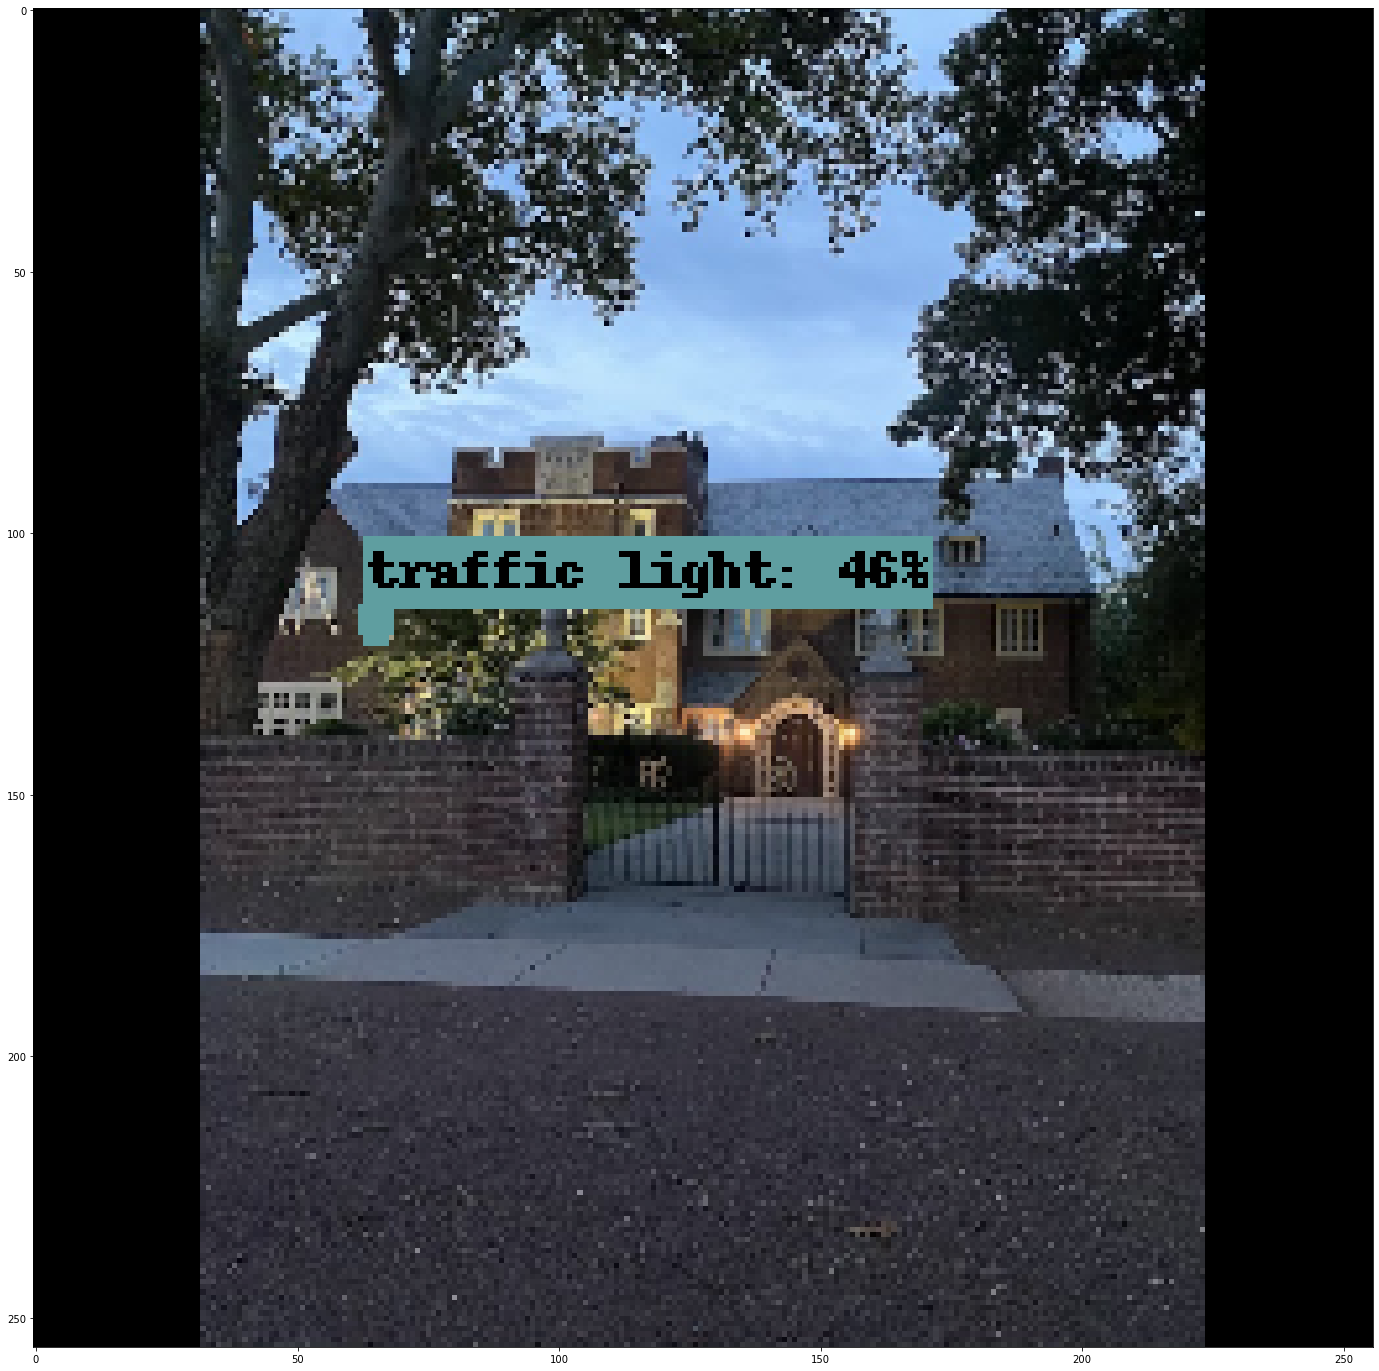

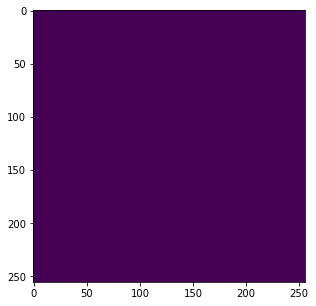

torch.Size([1, 1, 256, 256])
Inpainting...
Finish in inpaint_output


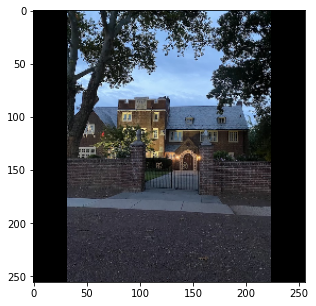

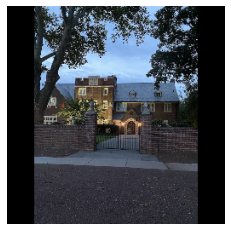

IMG_2629.JPG


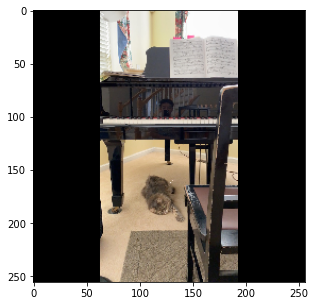

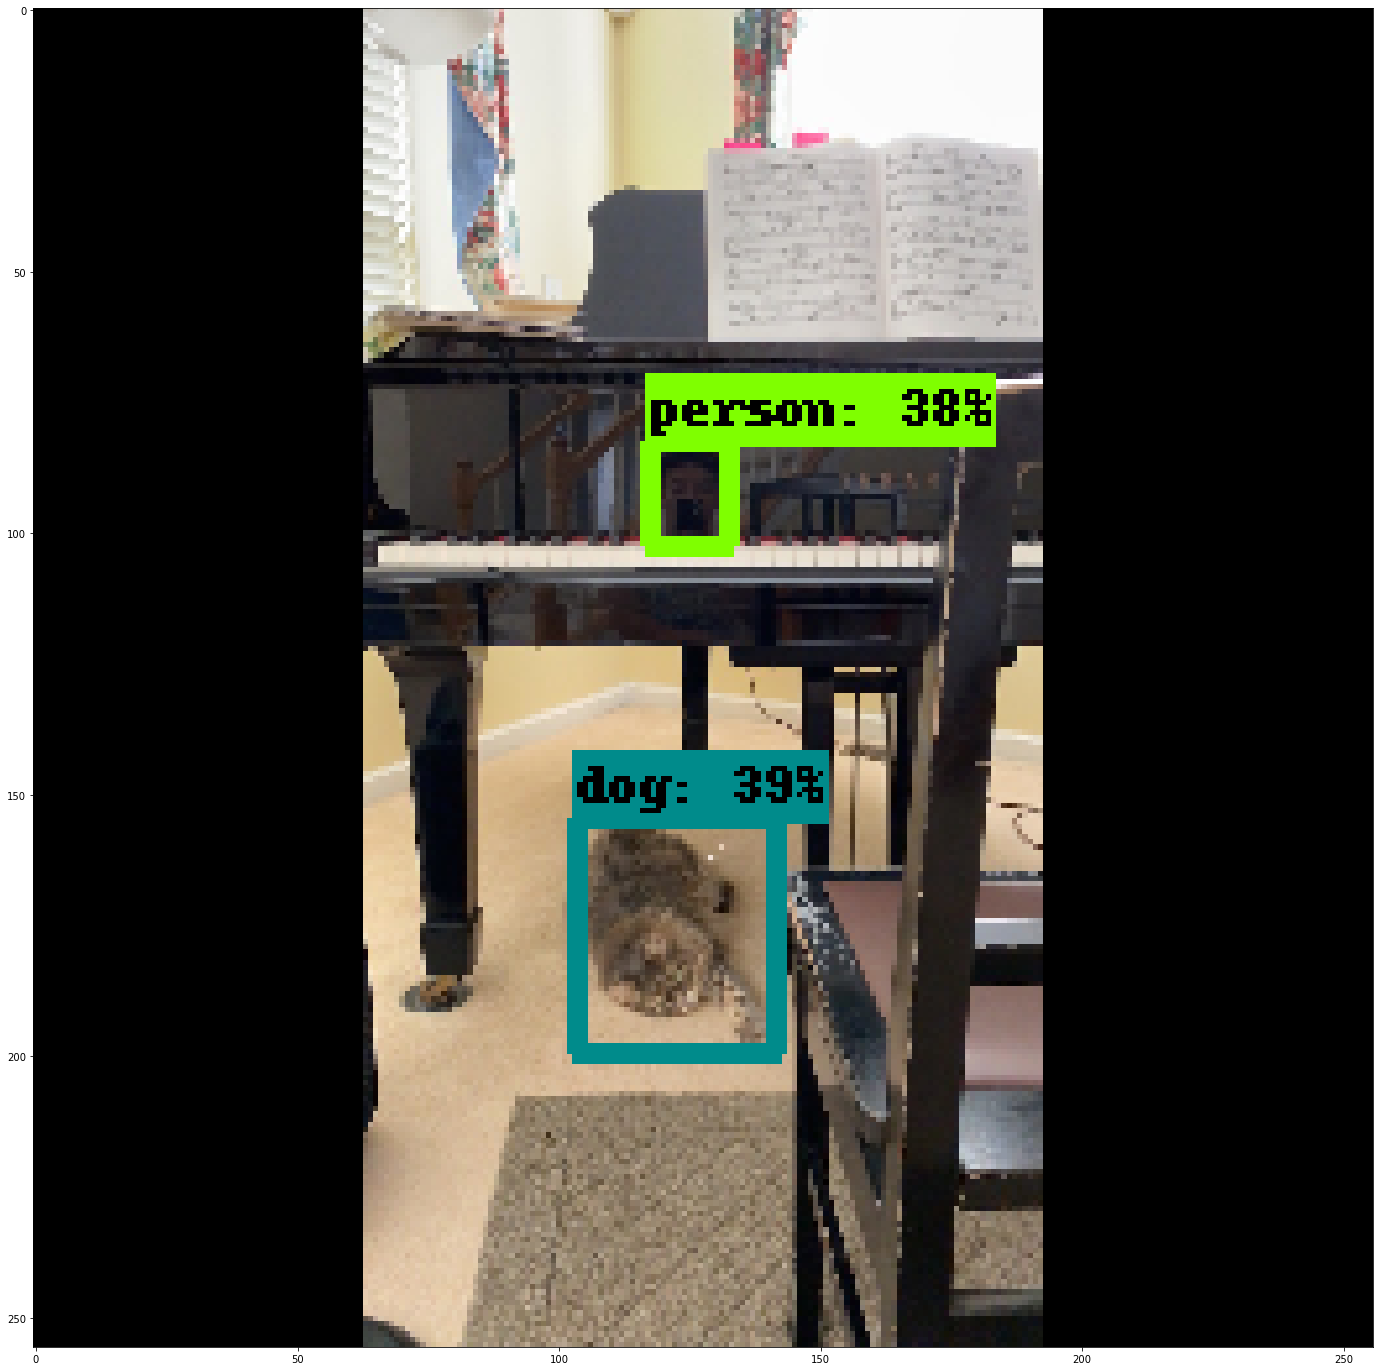

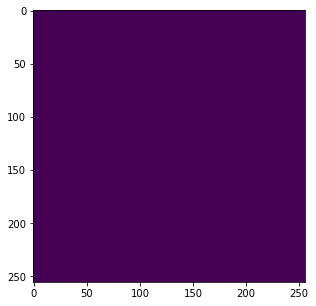

torch.Size([1, 1, 256, 256])
Inpainting...
Finish in inpaint_output


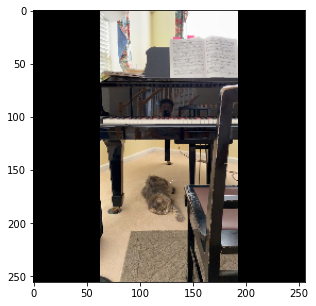

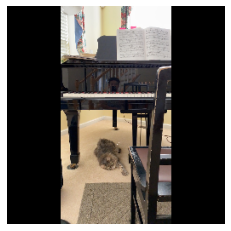

IMG_2838.jpeg


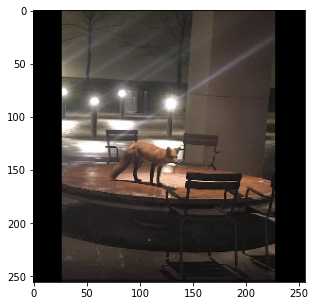

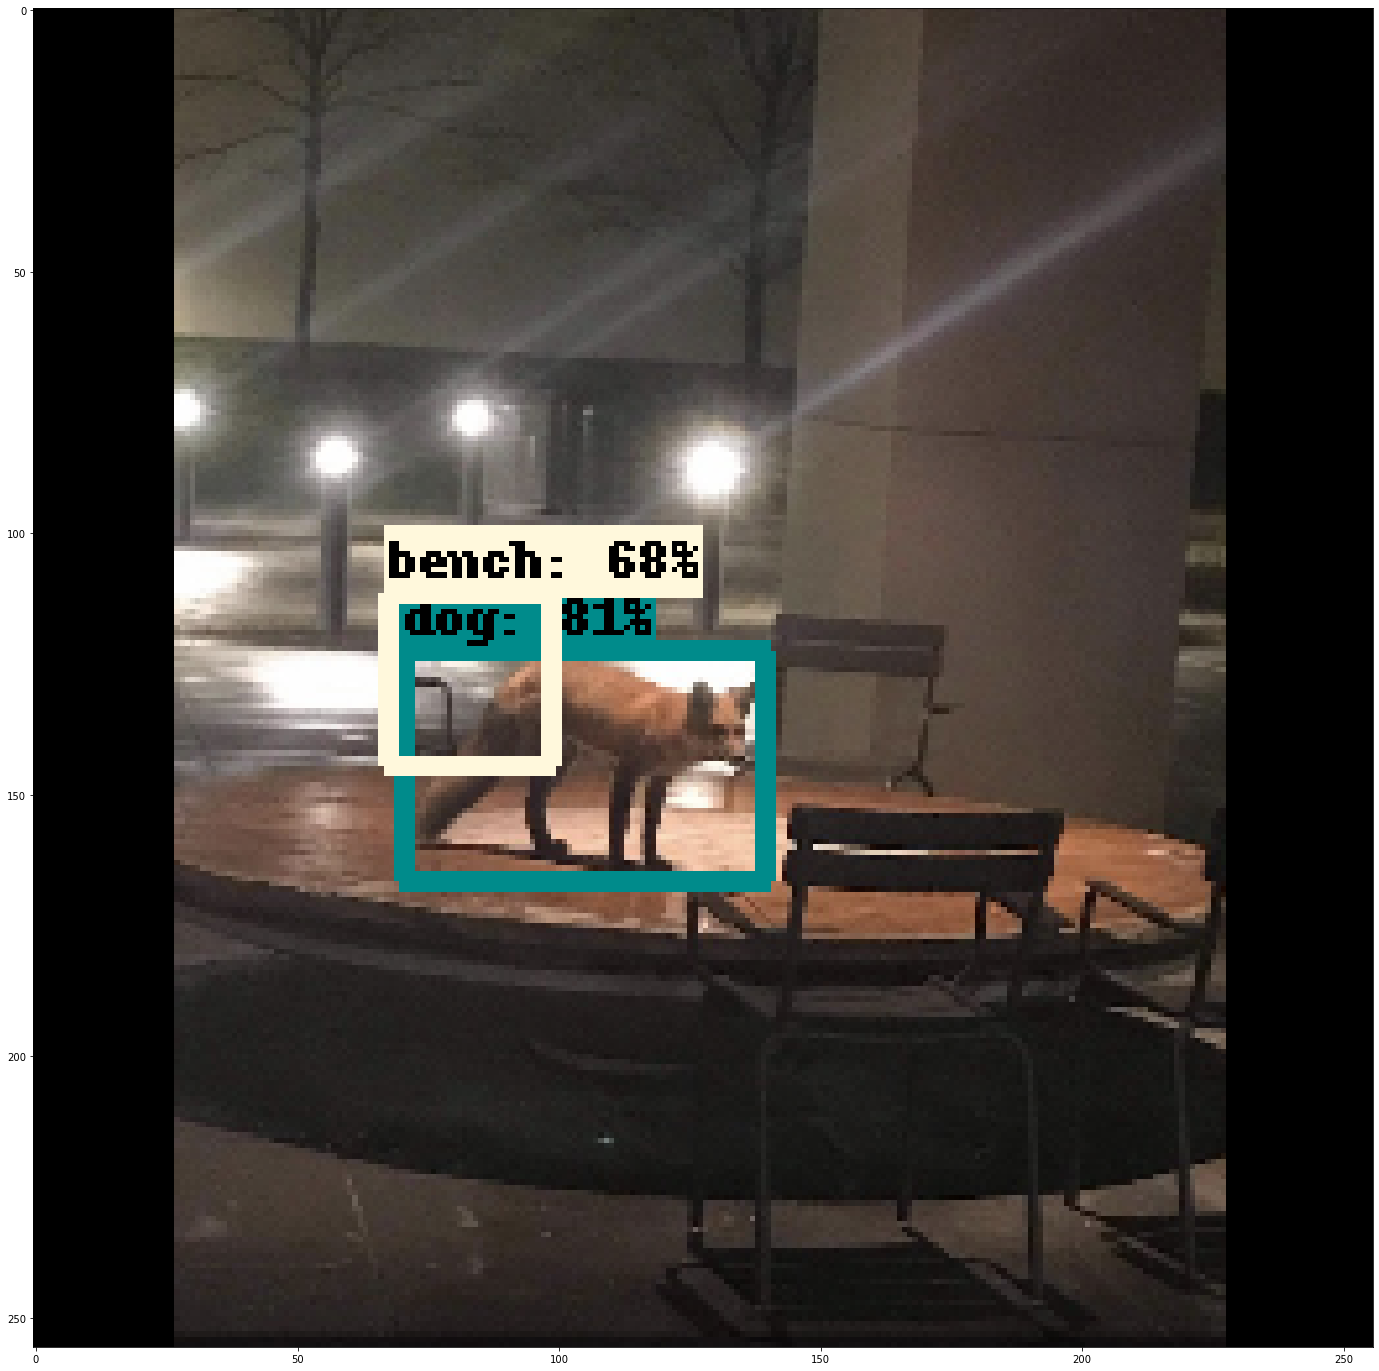

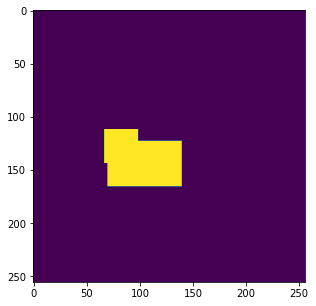

torch.Size([1, 1, 256, 256])
Inpainting...
Finish in inpaint_output


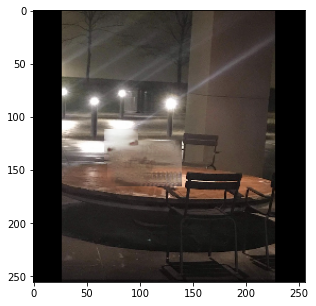

loading dog drawings
load complete
loading bench drawings
load complete


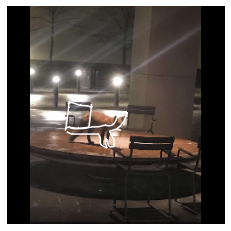

IMG_2208.jpeg


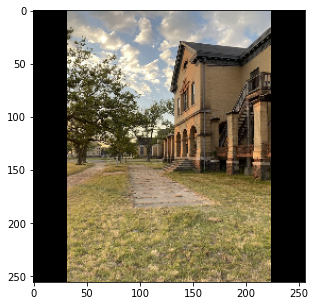

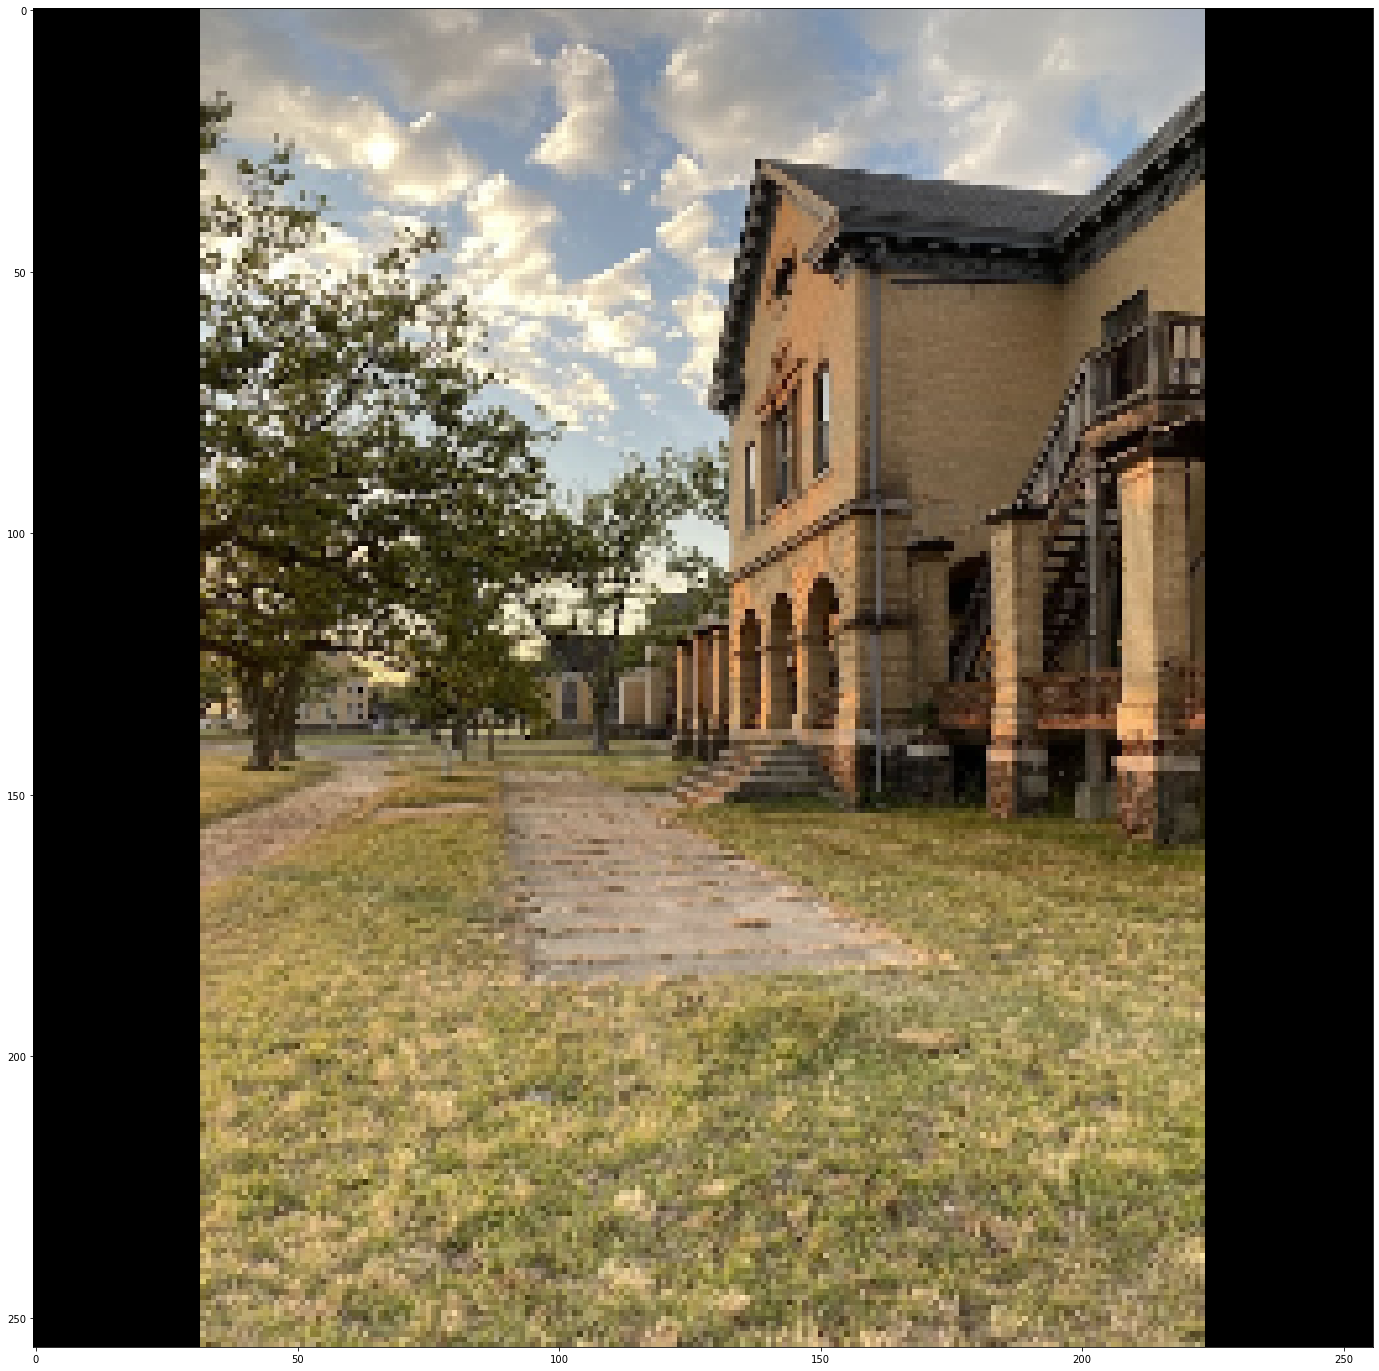

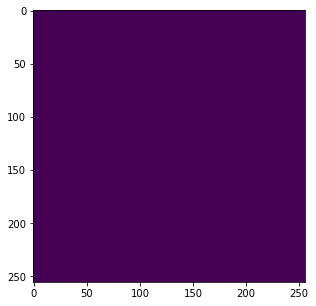

torch.Size([1, 1, 256, 256])
Inpainting...
Finish in inpaint_output


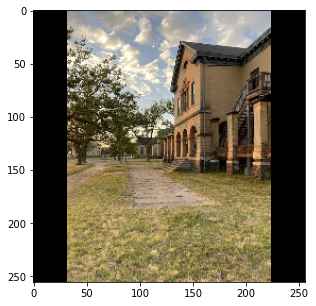

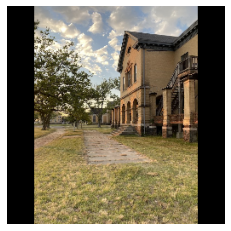

IMG_2884.JPG


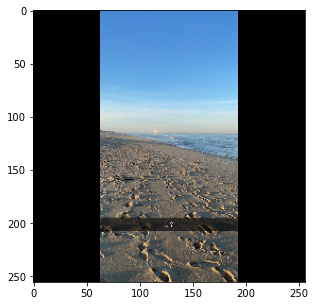

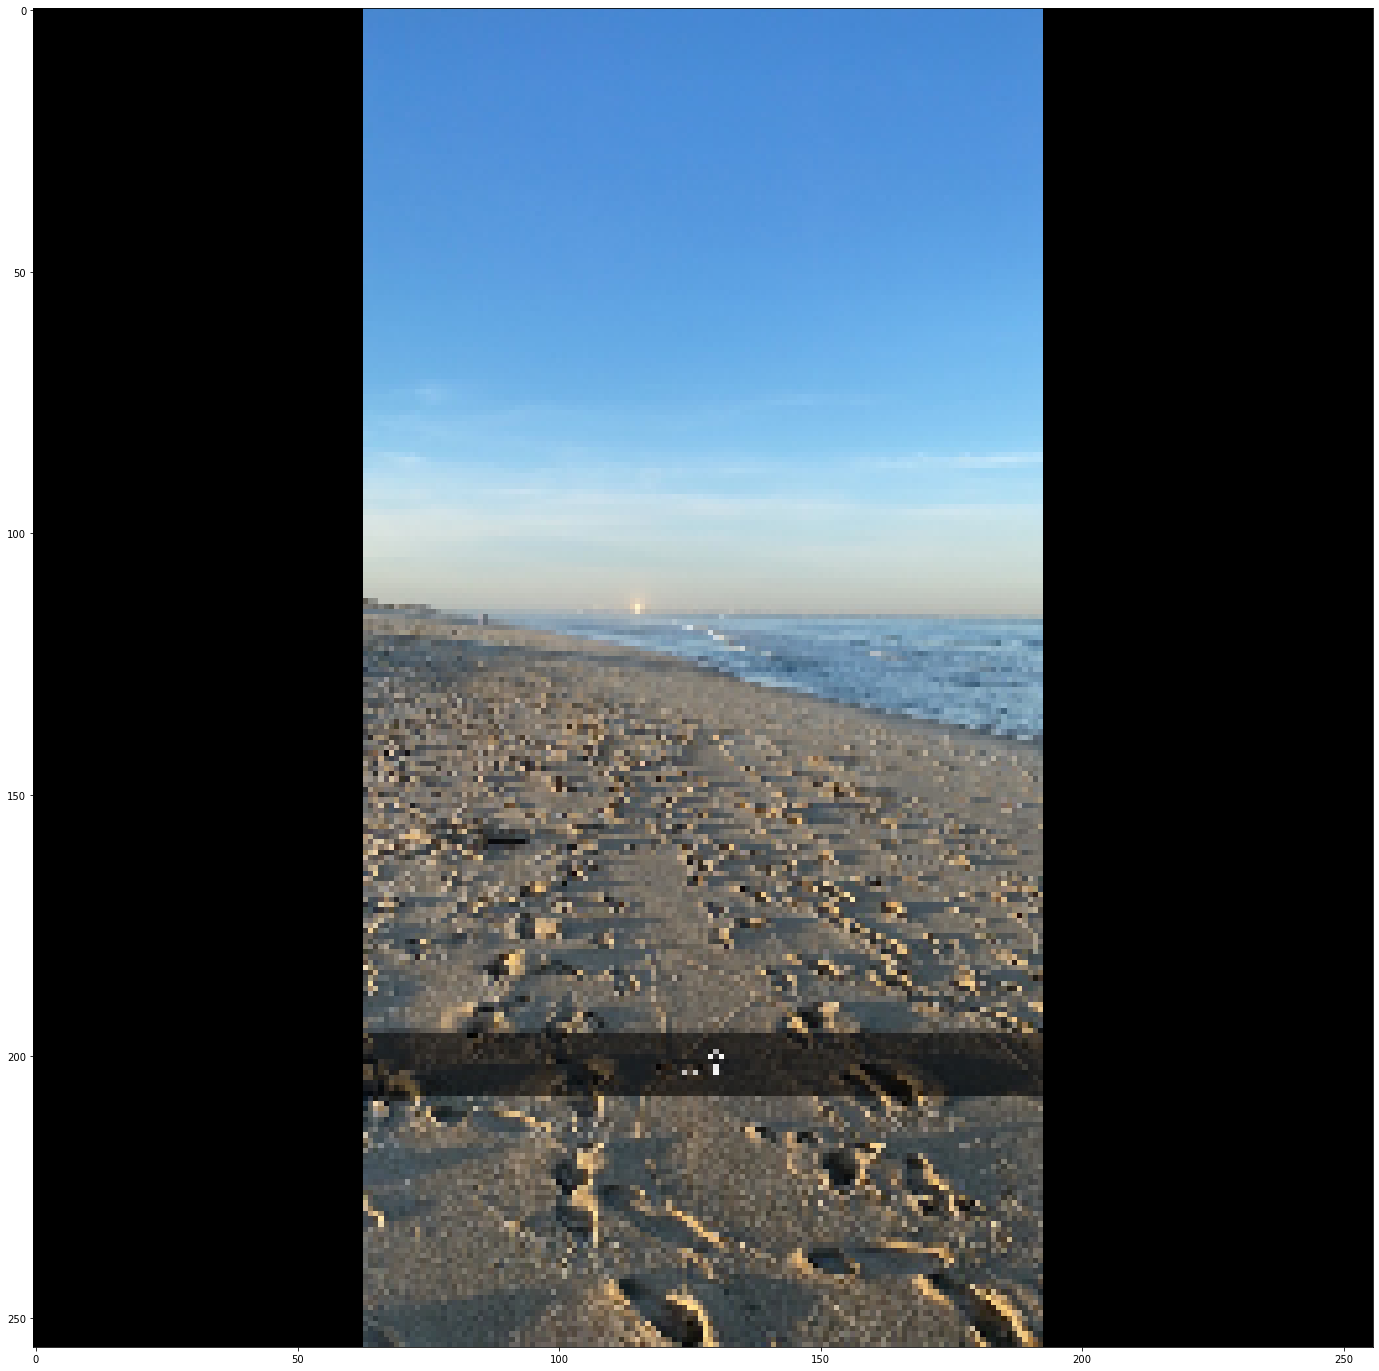

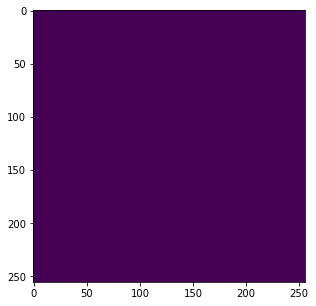

torch.Size([1, 1, 256, 256])
Inpainting...
Finish in inpaint_output


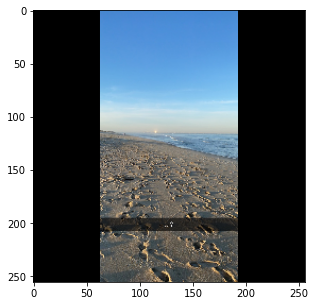

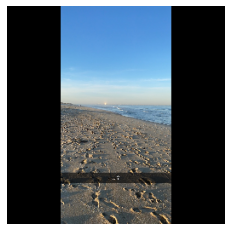

IMG_0711.jpeg


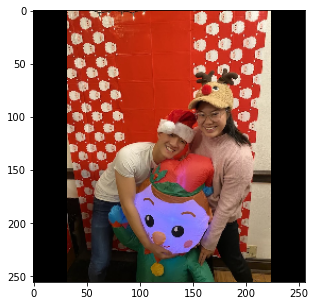

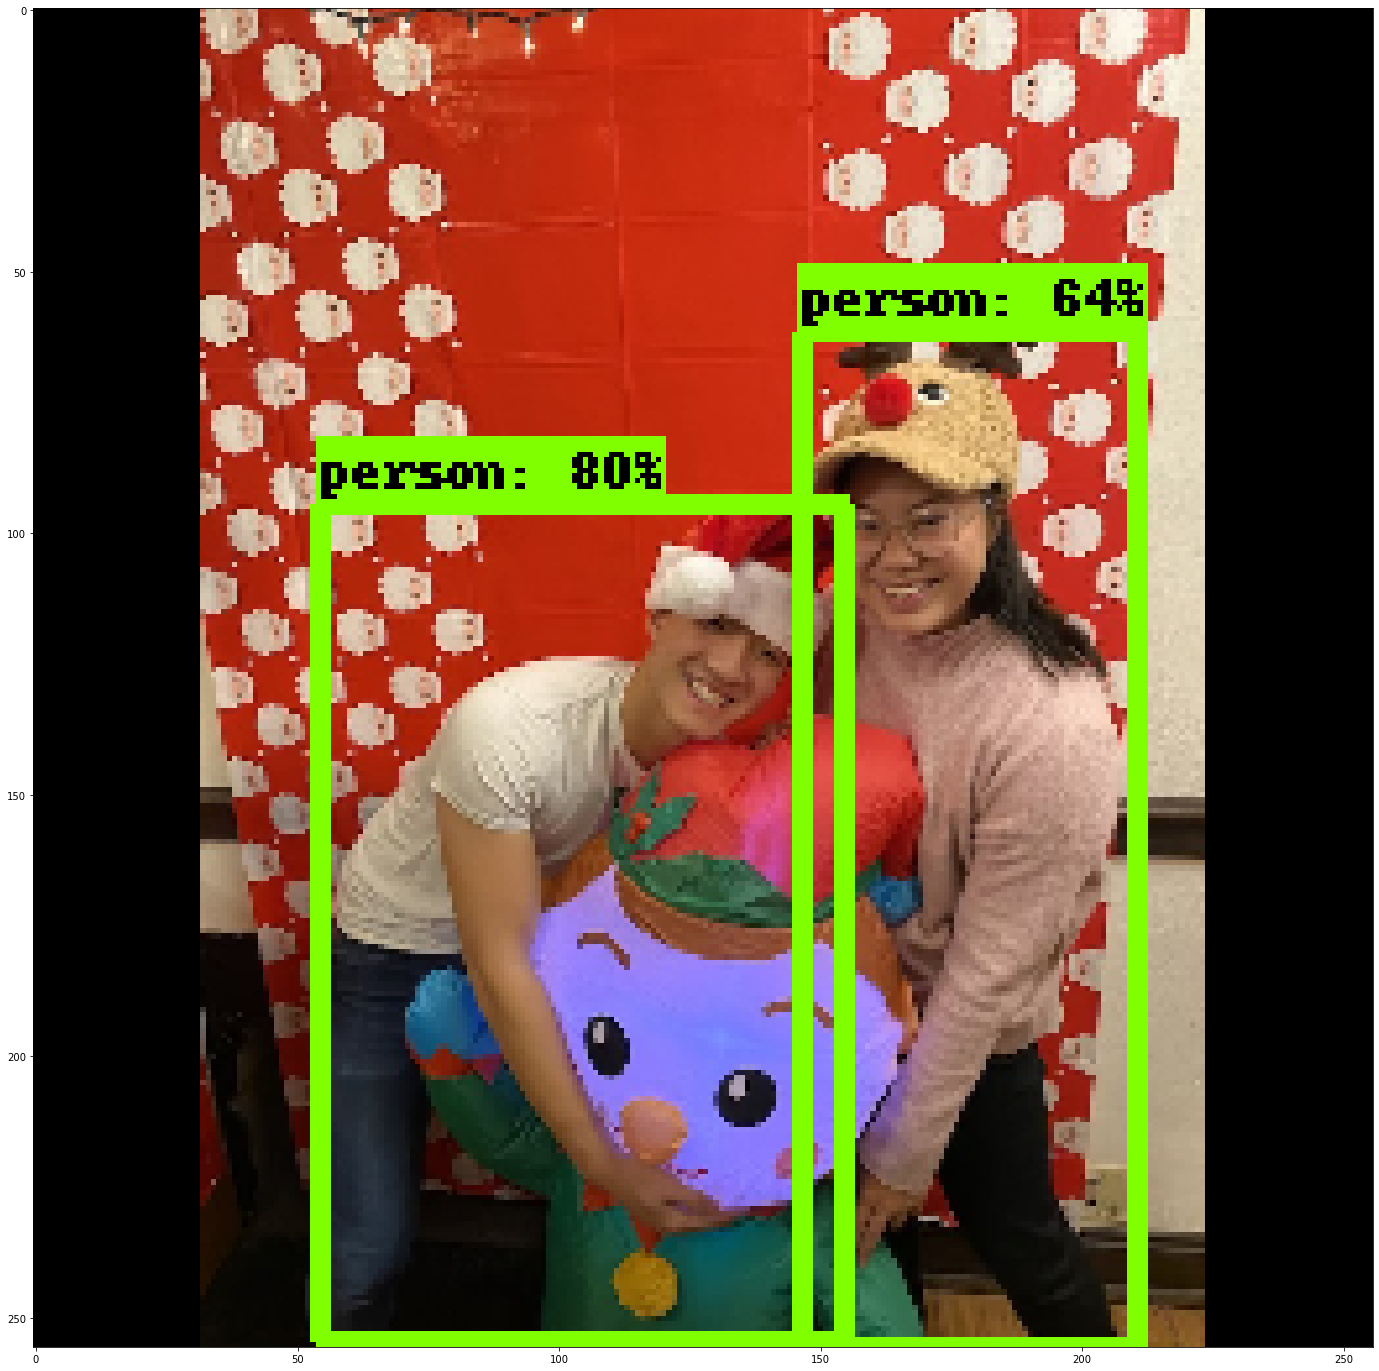

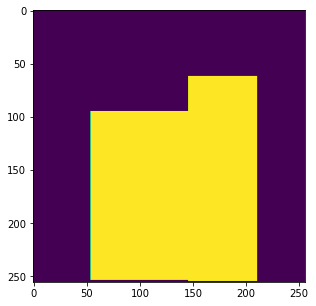

torch.Size([1, 1, 256, 256])
Inpainting...
Finish in inpaint_output


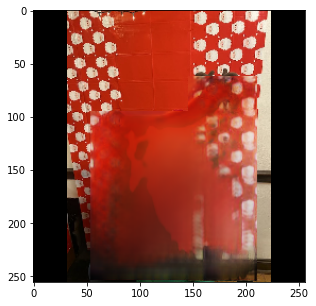

loading duck drawings
load complete


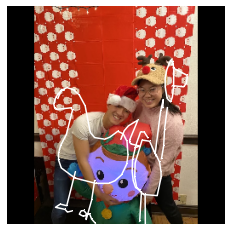

IMG_0969.jpeg


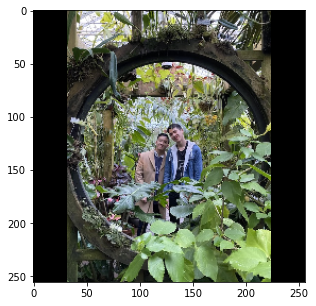

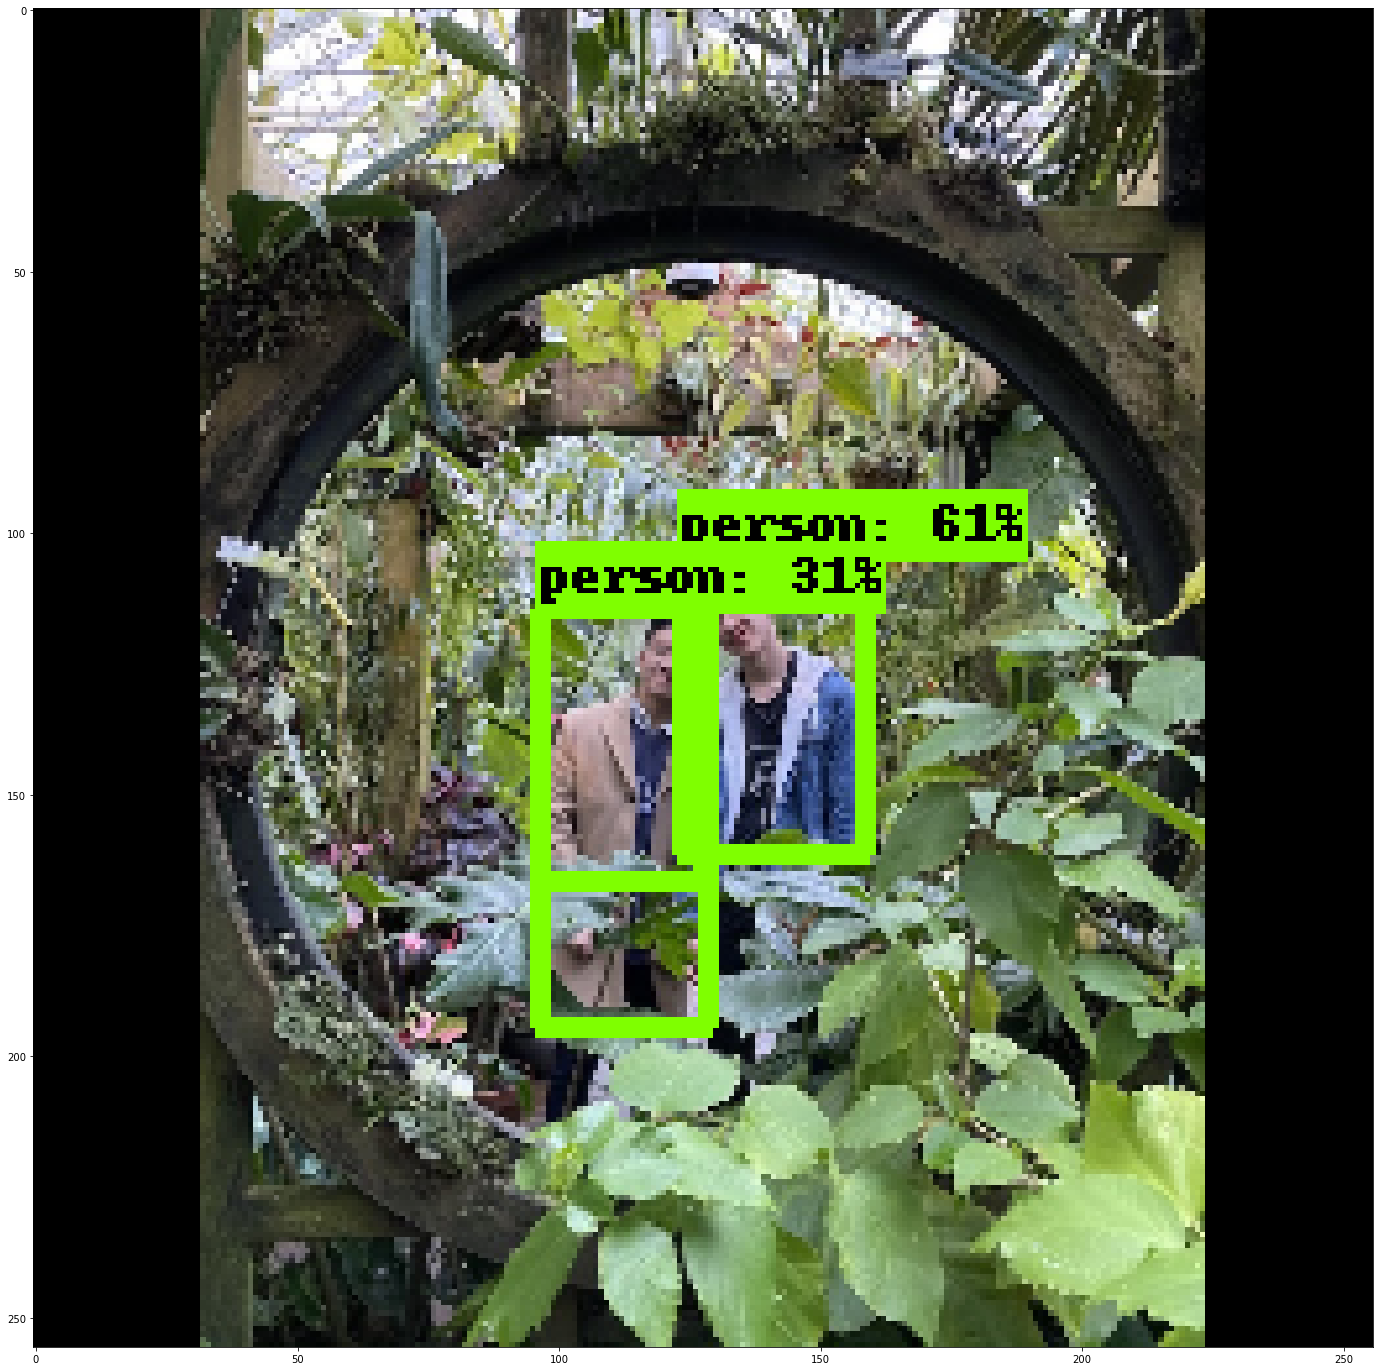

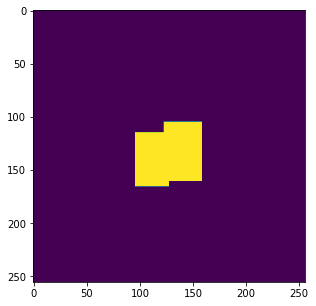

torch.Size([1, 1, 256, 256])
Inpainting...
Finish in inpaint_output


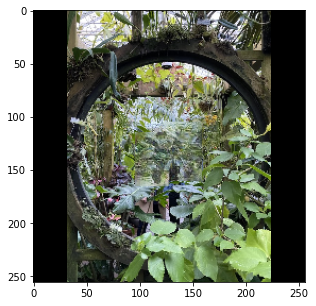

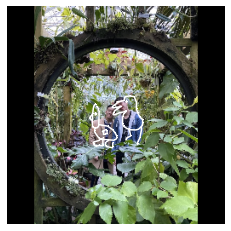

IMG_1206.JPG


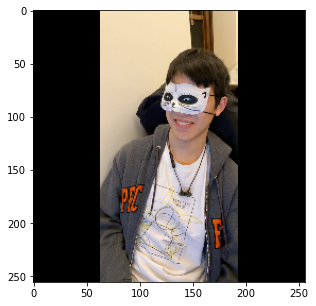

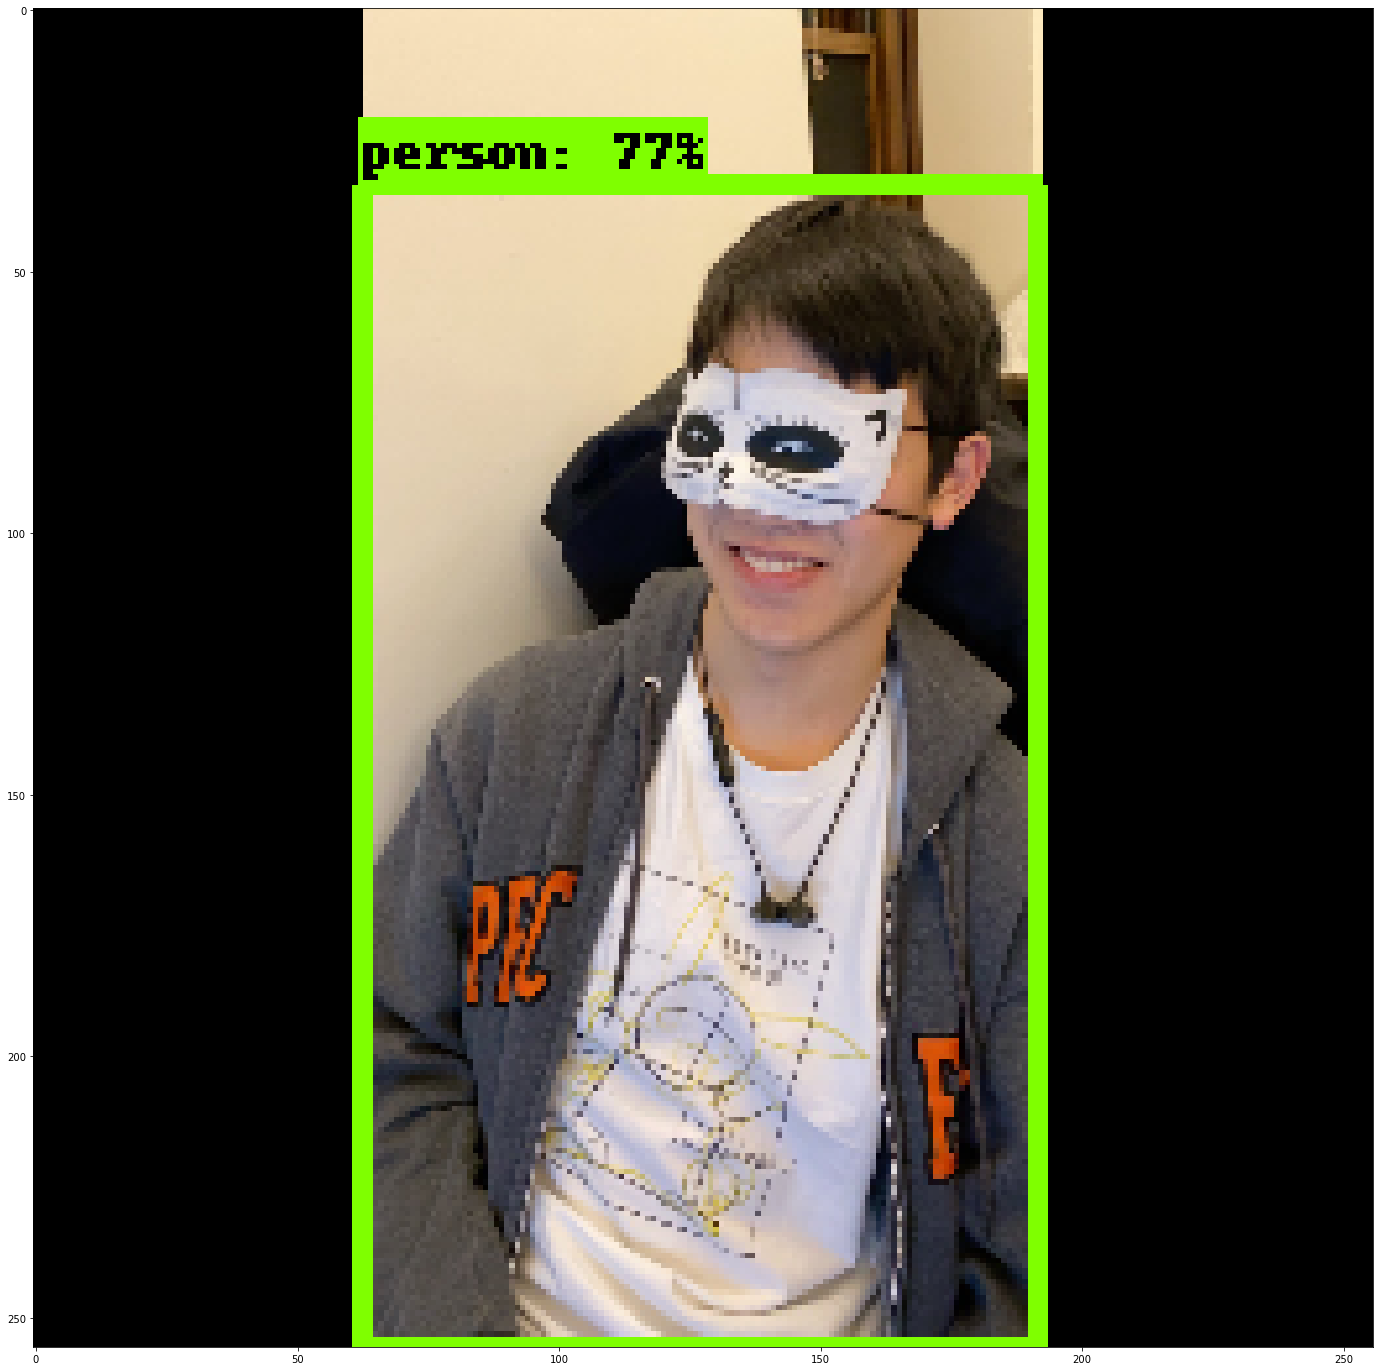

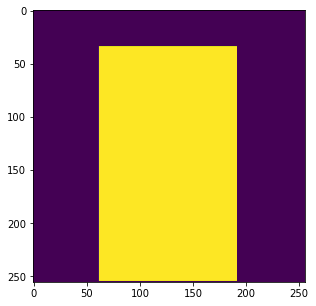

torch.Size([1, 1, 256, 256])
Inpainting...
Finish in inpaint_output


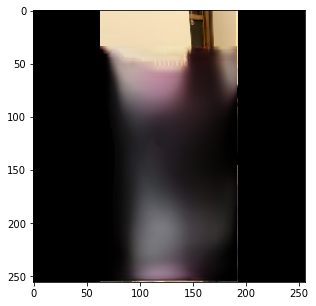

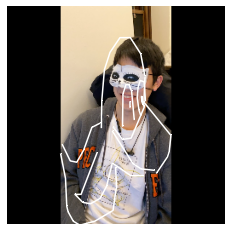

In [7]:

def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))

    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
          (1, im_height, im_width, 3)).astype(np.uint8)

def evaluate(object_detection, qd_dataset, source_path, sink_path):
    for filename in os.listdir(source_path):
        if filename.endswith(".JPG") or filename.endswith(".PNG") or filename.endswith(".jpeg"):
            print(filename)
            image_np = load_image_into_numpy_array(os.path.join(source_path, filename))
            resize_shape = 256
            resize_ratio = resize_shape / max(image_np.shape[1], image_np.shape[2])
#             image_np = np.expand_dims(cv2.resize(image_np[0], (256, 256)), axis=0)
            new_size = (int(round(image_np.shape[2]*resize_ratio)), int(round(image_np.shape[1]*resize_ratio)))
            im = cv2.resize(image_np[0], new_size)
            delta_h = resize_shape - new_size[1]
            delta_w = resize_shape - new_size[0]
            top, bottom = delta_h//2, delta_h-(delta_h//2)
            left, right = delta_w//2, delta_w-(delta_w//2)
            color = [0, 0, 0]
            new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
                value=color)
            plt.figure(figsize=(5,5))
            plt.imshow(new_im)
            plt.show()
            
            image_np = np.expand_dims(new_im, axis=0)
            
            detections = object_detection.inference(image_np, logging=True)
            pruned_detections = qd_dataset.prune_detections(image_np.shape[1:], detections, threshold=0.5)
            
            mask = inpainting.create_mask(pruned_detections, logging=True)
            image_inpainted = inpainting.inpaint(new_im, mask)
            
            drawn_image = qd_dataset.draw(image_np[0], pruned_detections, os.path.join(sink_path, filename))

evaluate(object_detection, qd_dataset, 'test_images', 'test_images_drawn')

In [ ]:
import torch

from torchvision import transforms

import torchvision.transforms.functional as F

from PIL import Image
import numpy as np
import os
import copy
import importlib
import datetime

from inpainting.core.utils import set_device, postprocess, set_seed

# image path the path to the image to read
# mask will be a path to an image as well with 255 in the mask locations
# both images should be of size 256x256.
def inpaint(img, mask=None):
    # torch.cuda.set_device(0)
    set_seed(2020)

    # Model and version
    model_dir = 'pen_inpaint_model'
    net = importlib.import_module('inpainting.model.pennet')
    model = set_device(net.InpaintGenerator())
    latest_epoch = open(os.path.join(model_dir, 'latest.ckpt'), 'r').read().splitlines()[-1]
    path = os.path.join(model_dir, 'gen_{}.pth'.format(latest_epoch))
    data = torch.load(path, map_location = lambda storage, loc: set_device(storage)) 
    model.load_state_dict(data['netG'])
    model.eval()

    path = 'inpaint_output'
    os.makedirs(path, exist_ok=True)
    
    if mask  == None: 
        mask = np.zeros((256, 256)).astype(np.uint8)
        mask[256//4:256*3//4, 256//4:256*3//4] = 255 
        mask = Image.fromarray(mask).convert('L')
        masks = F.to_tensor(mask)[None,:,:]
    else: 
#         mask = Image.open(mask_path).convert('L')
        masks = F.to_tensor(mask)[None, :,:]
        print(masks.shape)
    
#     img = Image.open(image_path).convert('RGB')
    img = F.to_tensor(img) * 2 -1.
    images = img[None, :,:,:]

    print('Inpainting...')
    images, masks = set_device([images, masks])
    images_masked = images*(1-masks) + masks
    with torch.no_grad():
        _, output = model(torch.cat((images_masked, masks), dim=1), masks)
    orig_imgs = postprocess(images)
    mask_imgs = postprocess(images_masked)
    comp_imgs = postprocess((1-masks)*images+masks*output)
    pred_imgs = postprocess(output)
    for i in range(len(orig_imgs)):
        Image.fromarray(pred_imgs[i]).save(os.path.join(path, 'output_pred.png'))
        Image.fromarray(orig_imgs[i]).save(os.path.join(path, 'output_orig.png'))
        Image.fromarray(comp_imgs[i]).save(os.path.join(path, 'output_comp.png'))
        Image.fromarray(mask_imgs[i]).save(os.path.join(path, 'output_mask.png'))
    print('Finish in {}'.format(path))
    
    plt.figure(figsize=(5,5))
    plt.imshow(comp_imgs)
    plt.show()
    
    return comp_imgs
    
def create_mask(img, pruned_detections, logging=False):
    mask = np.zeros((256, 256)).astype(np.uint8)

    for detection in pruned_detections:
        bbox = detection['bbox']
        y_dims = (int(bbox[1]), int(bbox[1]+bbox[3]))
        x_dims = (int(bbox[0]), int(bbox[0]+bbox[2]))
        mask[y_dims[0]:y_dims[1], x_dims[0]:x_dims[1]] = 255
    
    if logging:
        plt.figure(figsize=(5,5))
        plt.imshow(mask)
        plt.show()
    
    return mask
    

In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))

    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
          (1, im_height, im_width, 3)).astype(np.uint8)

def evaluate(object_detection, qd_dataset, source_path, sink_path):
    for filename in os.listdir(source_path):
        if filename.endswith(".JPG") or filename.endswith(".PNG") or filename.endswith(".jpeg"):
            print(filename)
            image_np = load_image_into_numpy_array(os.path.join(source_path, filename))
            plt.figure(figsize=(5,5))
            plt.imshow(image_np[0])
            plt.show()
            
            detections = object_detection.inference(image_np, logging=False)
            pruned_detections = qd_dataset.prune_detections(image_np.shape[1:], detections, threshold=0.5)
            drawn_image = qd_dataset.draw(image_np[0], pruned_detections, os.path.join(sink_path, filename))

evaluate(object_detection, qd_dataset, 'test_images', 'test_images_drawn')

Test For Object Detection

In [ ]:
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.

    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.

    Args:
    path: the file path to the image

    Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
    """
    image = None
    if(path.startswith('http')):
        response = urlopen(path)
        image_data = response.read()
        image_data = BytesIO(image_data)
        image = Image.open(image_data)
    else:
        image_data = tf.io.gfile.GFile(path, 'rb').read()
        image = Image.open(BytesIO(image_data))

    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
          (1, im_height, im_width, 3)).astype(np.uint8)

image_dir = 'models/research/object_detection/test_images'
for i in range(2):
    image_path = os.path.join(image_dir, 'image' + str(i + 1) + '.jpg')
    image_np = load_image_into_numpy_array(image_path)
    detections = object_detection.inference(image_np, logging=True)
    print(detections.keys())
    print(detections['detection_boxes'])
    print(detections['detection_classes'])
    print(detections['detection_scores'])

Test Object Detection on Coco Image

In [ ]:
img = cv2.imread('coco/val2017/000000001584.jpg',1)
Cimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(Cimg, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

dataDir='coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)
ids = [10673, 1584]
ids = [1584]
# ids= [10673, 638724, 2162813]
annIds = coco.getAnnIds(imgIds=ids)
anns = coco.loadAnns(annIds)
plt.imshow(Cimg); plt.axis('off')
coco.showAnns(anns)

In [ ]:
# object_detection = ObjectDetection()
detections = object_detection.inference(Cimg.reshape(1, *Cimg.shape), logging=True)

In [ ]:
print(detections.keys())
print(detections['detection_boxes'])
print(detections['detection_classes'])

Test Object Detections, Prune Detections, and Drawing Based on Detections

In [ ]:
qd_dataset = QuickDrawDataset()
# drawn_image = qd_dataset.draw(Cimg, "bus")
pruned_detections = qd_dataset.prune_detections(Cimg.shape, detections, threshold=0.5)
print(pruned_detections)
drawn_image = qd_dataset.draw(Cimg, pruned_detections)

Test Drawing using Coco prelabeled Detections

In [ ]:
catIds = coco.getCatIds(catNms=['bus']);
imgIds = coco.getImgIds(catIds=catIds );
imgIds = coco.getImgIds(imgIds = [1584])
img = coco.loadImgs(imgIds[np.random.randint(0,len(imgIds))])[0]
image = io.imread(img['coco_url'])

qd_dataset = QuickDrawDataset()
drawn_image = qd_dataset.draw(image, "bus")

In [ ]:
PATH_TO_LABELS = 'models/research/object_detection/data/mscoco_label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)
print(category_index.items())
print(category_index[1]['name'])

In [ ]:
img = cv2.imread('coco/val2017/000000001584.jpg',1)
Cimg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(Cimg, cmap = 'gray')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

dataDir='coco'
dataType='val2017'
annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
coco=COCO(annFile)
ids = [10673, 1584]
ids = [1584]
# ids= [10673, 638724, 2162813]
annIds = coco.getAnnIds(imgIds=ids)
anns = coco.loadAnns(annIds)
plt.imshow(Cimg); plt.axis('off')
coco.showAnns(anns)

In [ ]:
from quickdraw import QuickDrawData
qd = QuickDrawData()
anvil = qd.get_drawing("bus")

I = Cimg
plt.axis('off')

smallest_x = float('inf')
smallest_y = float('inf')
largest_x = 0
largest_y = 0
for stroke in anvil.strokes:
    xarr = []
    yarr = []
#    plt.plot(stroke, marker = 'o')

    for x, y in stroke:
        xarr.append(x)
        yarr.append(y)
        #plt.plot(x, y, marker = ',')
        #print("x={} y={}".format(x, y))
        if(x <= smallest_x):
            smallest_x = x
        if(y <= smallest_y):
            smallest_y = y
        if(x >= largest_x):
            largest_x = x
        if(y >= largest_y):
            largest_y = y
    
#     plt.plot(xarr,yarr, marker = ',', color="white")

width = largest_x-smallest_x
height = largest_y - smallest_y

print(smallest_x)
print(width, 'width')
print(largest_y)
print(height, 'height')

for ann in anns:
    [bbox_x, bbox_y, bbox_w, bbox_h] = ann['bbox']
    for stroke in anvil.strokes:
        xarr = []
        yarr = []
        for x, y in stroke:
            xarr.append(x)
            yarr.append(y)

        newx = [x * (bbox_w/width) + bbox_x for x in xarr]
        newy = [y * (bbox_h/height) + bbox_y for y in yarr]
        plt.plot(newx,newy, marker = ',', color="white")
    #print(bbox_x)

plt.imshow(I)
plt.show()

In [ ]:
print(anns)
boxes = {}
for ann in anns:
    boxes[ann['id']] = ann['bbox']
print(boxes)